# Adding SQL Scrpit 

In [27]:
import pandas as pd
from sqlalchemy import create_engine, text
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy.stats import pearsonr
import numpy as np

In [2]:
user = "root"
password = "1234abcd" # Jose You should change this to your password
host = "127.0.0.1"
port = "3306"
db = "mydb" # Jose You should change this to your database name

engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{db}')

# 8. **Rating Trends Over Time**:
   ### Hypothesis: The average rating given by users has changed over time, potentially increasing or decreasing due to changes in user expectations and movie quality.

The SQL query is designed to calculate the average rating given by users for each year. It does this by extracting the year from a timestamp and then computing the average rating for that year. The results are then ordered by year.

In [3]:
query = """
SELECT
    YEAR(FROM_UNIXTIME(ratings_small.timestamp)) AS year,
    AVG(ratings_small.rating) AS average_rating
FROM
    ratings_small
GROUP BY
    YEAR(FROM_UNIXTIME(ratings_small.timestamp))
ORDER BY
    year;
"""


- Create a Connection: Establishes a connection to the database.
- Execute the Query and Read the Result: Executes an SQL query and reads the results into a pandas DataFrame.
- Print the Result: Outputs the first few rows of the DataFrame for inspection.
- Close the Connection: Terminates the connection to the database to free up resources.

In [5]:
# create a connection
connection = engine.connect()

# execute the query and read the result
hypothesis_1_df = pd.read_sql(text(query), connection)
# print the result
print(hypothesis_1_df.head())

# close the connection
connection.close()

   year  average_rating
0  1996         3.80769
1  1997         3.76190
2  1998         3.66667
3  1999         4.02500
4  2000         3.79452


In [11]:
subject = hypothesis_1_df['year']
score = hypothesis_1_df['average_rating']

data = [dict(
  type = 'scatter',
  x = subject,
  y = score,
  mode = 'markers'
)]

layout = dict(
    title = 'Year vs Average rating',
    xaxis = dict(
        title = 'Year',
        range = [1995, 2016]
                 ),
    yaxis = dict(
        title = 'Average rating',
        range = [0, 5]
        )
)

fig_dict = dict(data=data, layout=layout)

pio.show(fig_dict, validate=False)

# 10. **Movie Popularity and Rating**:
###    Hypothesis: Movies with higher vote counts tend to have higher average ratings.

In [12]:
query = """
SELECT
    id AS movie_id,
    AVG(vote_average) AS average_rating,
    vote_count
FROM
    movies_metadata
GROUP BY
    id
ORDER BY
    vote_count DESC;
"""


- Create a Connection: Establishes a connection to the database.
- Execute the Query and Read the Result: Executes an SQL query and reads the results into a pandas DataFrame.
- Print the Result: Outputs the first few rows of the DataFrame for inspection.
- Close the Connection: Terminates the connection to the database to free up resources.

In [14]:
# create a connection
connection = engine.connect()

# execute the query and read the result
hypothesis_2_df = pd.read_sql(text(query), connection)
# print the result
print(hypothesis_2_df.head())

# close the connection
connection.close()

   movie_id  average_rating  vote_count
0        13             8.2        8147
1       862             7.7        5415
2       329             7.6        4956
3        78             7.9        3833
4      9479             7.6        2135


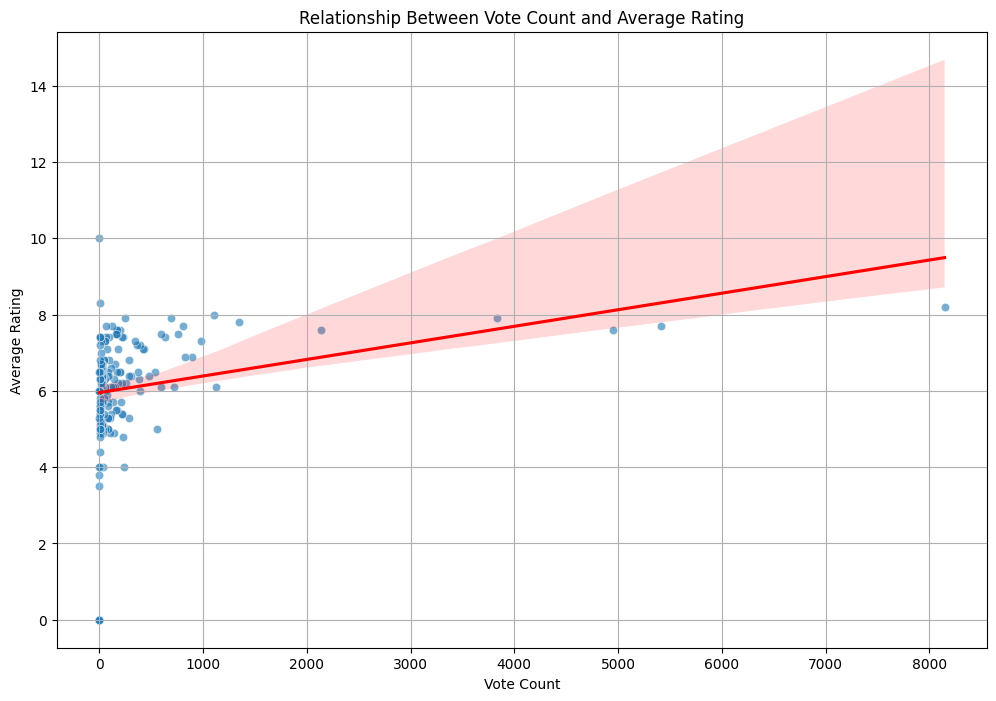

In [16]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='vote_count', y='average_rating', data=hypothesis_2_df, alpha=0.6)
sns.regplot(x='vote_count', y='average_rating', data=hypothesis_2_df, scatter=False, color='red')
plt.title('Relationship Between Vote Count and Average Rating')
plt.xlabel('Vote Count')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

In [24]:
fig = px.scatter(hypothesis_2_df, x='vote_count', y='average_rating',
                 labels={'vote_count': 'Vote Count', 'average_rating': 'Average Rating'},
                 title='Relationship Between Vote Count and Average Rating',
                 trendline='ols',
                 trendline_color_override='red') 
fig.show()

# 11. **High Budget, High Rating**:
### Hypothesis: Movies with higher budgets tend to receive higher average ratings from users.

In [25]:
query = """
SELECT
    id AS movie_id,
    budget,
    AVG(vote_average) AS average_rating
FROM
    movies_metadata
GROUP BY
    id, budget
ORDER BY
    budget DESC;
"""


- Create a Connection: Establishes a connection to the database.
- Execute the Query and Read the Result: Executes an SQL query and reads the results into a pandas DataFrame.
- Print the Result: Outputs the first few rows of the DataFrame for inspection.
- Close the Connection: Terminates the connection to the database to free up resources.

In [26]:
# create a connection
connection = engine.connect()

# execute the query and read the result
hypothesis_3_df = pd.read_sql(text(query), connection)
# print the result
print(hypothesis_3_df.head())

# close the connection
connection.close()

   movie_id    budget  average_rating
0      1408  98000000             5.7
1      9593  85000000             6.1
2      3595  80000000             6.4
3      9350  70000000             6.1
4      9333  67000000             6.2


In [30]:

# Create the scatter plot with Plotly
df = hypothesis_3_df
correlation, p_value = pearsonr(df['budget'], df['average_rating'])

fig = px.scatter(df, x='budget', y='average_rating',
                 labels={'budget': 'Budget', 'average_rating': 'Average Rating'},
                 title='Relationship Between Budget and Average Rating',
                 trendline='ols',
                 trendline_color_override='red',
                 size='average_rating',  # size of points based on average rating
                 hover_name='movie_id',  # hover info to display movie ID
                 color='average_rating',  # color points based on average rating
                 color_continuous_scale=px.colors.sequential.Viridis)  # color scale

# Customize the layout to center the title and add more styling
fig.update_layout(
    title={'text': 'Relationship Between Budget and Average Rating', 'x': 0.5, 'xanchor': 'center'},
    xaxis_title='Budget (in $)',
    yaxis_title='Average Rating',
    font=dict(family='Arial, sans-serif', size=14, color='black'),
    plot_bgcolor='rgba(0, 0, 0, 0)',  # transparent background
    paper_bgcolor='rgba(255, 255, 255, 1)',  # white background
    xaxis=dict(showgrid=True, gridcolor='LightGrey'),
    yaxis=dict(showgrid=True, gridcolor='LightGrey')
)

# Add annotations for the correlation coefficient and p-value
fig.add_annotation(
    x=max(df['budget']),
    y=min(df['average_rating']),
    text=f'Correlation: {correlation:.2f}<br>P-value: {p_value:.2e}',
    showarrow=False,
    font=dict(size=12, color='black'),
    align='left',
    xanchor='right',
    yanchor='bottom',
    bordercolor='black',
    borderwidth=1
)

# Show the plot
fig.show()



# 14. Popularity's Impact:
  ###  Hypothesis: Movies which are popular tend to have higher ratings.

In [42]:
query = """
SELECT 
    movies_metadata.title,
    movies_metadata.popularity,
    AVG(ratings_small.rating) AS user_avg_rating
FROM 
    movies_metadata 
JOIN 
    links_small ON movies_metadata.imdb_id = links_small.imdbId
JOIN 
    ratings_small ON links_small.movieId = ratings_small.movieId
GROUP BY 
    movies_metadata.title, movies_metadata.popularity;
"""


- Create a Connection: Establishes a connection to the database.
- Execute the Query and Read the Result: Executes an SQL query and reads the results into a pandas DataFrame.
- Print the Result: Outputs the first few rows of the DataFrame for inspection.
- Close the Connection: Terminates the connection to the database to free up resources.

In [45]:
# create a connection
connection = engine.connect()

# execute the query and read the result
hypothesis_4_df = pd.read_sql(text(query), connection)
# print the result
print(hypothesis_4_df.head())

# close the connection
connection.close()

                            title popularity  user_avg_rating
0                       Toy Story  21.946943          3.87247
1                      Get Shorty  12.669608          3.85714
2  Ace Ventura: When Nature Calls   8.205448          2.57143
3                          Powder  12.133094          3.04545
4                          Casino  10.137389          3.63158


In [78]:
# Sort the DataFrame by the 'popularity' column in descending order
hypothesis_4_df = hypothesis_4_df.sort_values(by='popularity', ascending=False)

# Create the bar plot
fig = px.bar(hypothesis_4_df, x='title', y='user_avg_rating',
             color='popularity',  # color bars based on popularity
             labels={'title': 'Movie Title', 'user_avg_rating': 'Average User Rating', 'popularity': 'Popularity'},
             title='Average User Ratings and Popularity of Movies',
             color_continuous_scale=px.colors.sequential.Turbo)  # color scale


# Add a trendline to the bar plot
x_values = np.arange(len(hypothesis_4_df))
z = np.polyfit(x_values, hypothesis_4_df['user_avg_rating'], 1)
p = np.poly1d(z)
trendline = p(x_values)
# Add the trendline to the bar plot
fig.add_trace(go.Scatter(x=hypothesis_4_df['title'], y=trendline, mode='lines', name='Trendline', line=dict(color='black', width=4)))

# Customize the layout to center the title and add more styling
fig.update_layout(
    title={'text': 'Average User Ratings and Popularity of Movies', 'x': 0.5, 'xanchor': 'center'},
    xaxis_title='Movie Title',
    yaxis_title='Average User Rating',
    font=dict(family='Arial, sans-serif', size=14, color='black'),
    plot_bgcolor='rgba(0, 0, 0, 0)',  # transparent background
    paper_bgcolor='rgba(255, 255, 255, 1)',  # white background
    xaxis=dict(showgrid=True, gridcolor='LightGrey'),
    yaxis=dict(showgrid=True, gridcolor='LightGrey')
)

# Show the plot
fig.show()
